In [1]:
import time

import matplotlib.pyplot as plt
import monai
import monai.transforms
import numpy as np
import torch
from monai.config import print_config
from monai.transforms import ScaleIntensityd
from tqdm import tqdm

# print_config()
from dataset import HNTSDataset, create_dataset_dicts

dataset = HNTSDataset("data/train", monai.transforms.Compose([
    monai.transforms.ScaleIntensityd(keys='image')
]))

# dataset = monai.data.CacheDataset(create_dataset_dicts("data/train"), monai.transforms.LoadImaged(keys=["image", "mask"]))
# dataset_test = monai.data.CacheDataset(create_dataset_dicts("data/test"), monai.transforms.LoadImaged(keys=["image", "mask"]))

Loading dataset: 100%|██████████| 130/130 [01:16<00:00,  1.70it/s]


In [2]:
# Is the data isotropically spaced?
spacing = dataset[0]['image'].affine.diagonal()[:3].abs()
spacing  # all equal, so yes

tensor([1., 1., 1.], dtype=torch.float64)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
sample_idx = 10
sample = dataset[sample_idx]
image = monai.transforms.Orientation(axcodes="SPL")(sample['image'])
mask = monai.transforms.Orientation(axcodes="SPL")(sample['mask'])
def plot_slice(slice_idx):
    image_slice =  image[0,slice_idx]
    label0 = mask[0,slice_idx]
    label1 = mask[1,slice_idx]
    
    plt.figure(figsize=(8,8))
    plt.imshow(image_slice, cmap="gray", alpha=1.0)
    plt.imshow(label0, cmap="Reds", alpha=0.3)
    plt.imshow(label1, cmap="plasma", alpha=0.3)
    plt.axis("off")
    
    plt.show()
slider = widgets.IntSlider(value=mask.shape[1]//2, min=0, max=mask.shape[1]-1, step=1, description='Slice Index')
interact(plot_slice, slice_idx=slider);

interactive(children=(IntSlider(value=84, description='Slice Index', max=168), Output()), _dom_classes=('widge…

In [4]:
# Check data shapes
shape_len = dataset[0]['mask'].shape.__len__()
shape_tensor = torch.zeros((len(dataset), shape_len))
for i, data in enumerate(tqdm(dataset)):
    mask = data['mask']
    shape_tensor[i] = torch.tensor(mask.shape)

max_d = torch.zeros(shape_len)
min_d = torch.zeros(shape_len)
for d in range(shape_tensor.shape[1]):
    min_d[d] = shape_tensor[:, d].min()
    max_d[d] = shape_tensor[:, d].max()
    print(d, shape_tensor[:, d].shape)
min_d, max_d

100%|██████████| 20/20 [00:01<00:00, 10.48it/s]

0 torch.Size([20])
1 torch.Size([20])
2 torch.Size([20])
3 torch.Size([20])


(tensor([  2., 256., 256., 123.]), tensor([  2., 520., 520., 173.]))

metatensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
      

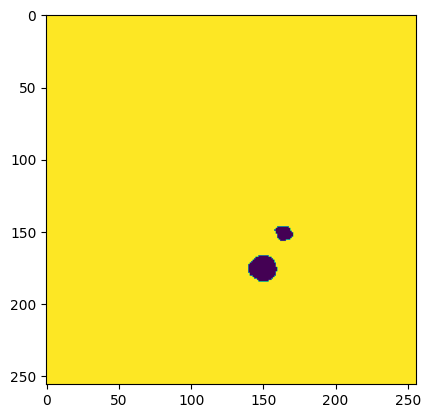

In [ ]:
import matplotlib.pyplot as plt
dataset[0]['mask'][2]
plt.imshow(dataset[0]['mask'][0][:,:,80])

(dataset[0]['mask'][2] == 1)

In [16]:
class_counts = np.array([0, 0, 0], dtype=np.float32)
for data in tqdm(dataset):
    mask = data['mask']
    counts = np.array([len(mask[idx][mask[idx] == 1]) for idx in range(3)])  #/ len(dataset)
    class_counts += counts
class_counts

100%|██████████| 130/130 [00:44<00:00,  2.95it/s]


array([1.9928758e+09, 1.2954240e+06, 1.7363210e+06], dtype=float32)

In [18]:
100* class_counts[1:].sum() / class_counts.sum()

0.15189807477727063

In [ ]:
n = class_counts[1:].sum()
c = 2
# Class weights
n / (c * class_counts)

In [ ]:
avg_mask = torch.zeros_like(dataset[0]['mask'])
for data in tqdm(dataset):
    avg_mask += data['mask']
avg_mask /= len(dataset)

  1%|          | 1/130 [00:00<00:39,  3.23it/s]


RuntimeError: The size of tensor a (149) must match the size of tensor b (163) at non-singleton dimension 2

In [ ]:
plt.imshow(avg_mask.cpu().mean(3).permute(1, 2, 0))
plt.axis('off')
plt.title("Average tumor pixels");

In [ ]:
plt.plot(torch.tensor([t.sum() for t in avg_mask[0].permute(2, 0, 1)]))
plt.xlabel("Z-level")
plt.ylabel("Tumor pixels")
plt.title("Average tumor Z-location")
plt.tight_layout();

In [ ]:
# Tumor percentage
total_pixels = torch.tensor(dataset[0]['mask'].shape).prod()
total_tumor = 0
total_non_tumor = 0
for data in tqdm(dataset):
    total_tumor += data['mask'].sum() / total_pixels
total_tumor /= len(dataset)
total_tumor

In [ ]:
max_ = 0
min_ = 1000
for data in tqdm(dataset):
    image = data['image']
    curr_max = image.max()
    curr_min = image.min()
    max_ = max_ if max_ >= curr_max else curr_max
    min_ = min_ if min_ <= curr_min else curr_min
min_, max_

100%|██████████| 130/130 [00:19<00:00,  6.63it/s]


(metatensor(0.), metatensor(1.))

In [44]:
# Calculate intensity distribution
bincounts = torch.zeros(130, 256)
for i, data in enumerate(tqdm(dataset)):
    intensity_values = data['image'].flatten().divide(max_).multiply(255).round().int()
    bincount = torch.bincount(intensity_values, minlength=256)
    bincounts[i, :len(bincount)] = bincount

  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 130/130 [00:29<00:00,  4.41it/s]


In [ ]:
torch.optim.Adam(lr=)

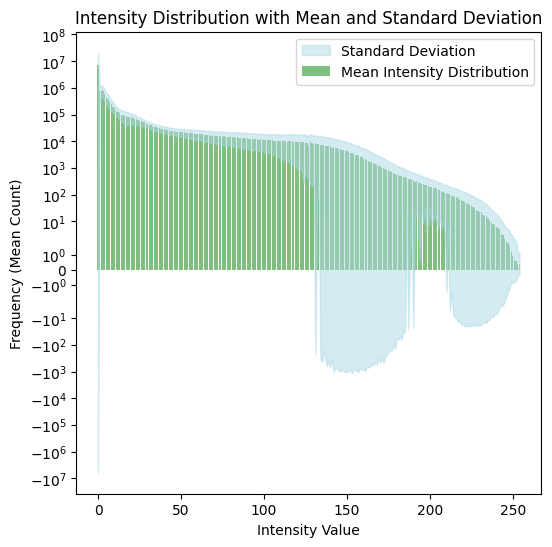

In [45]:
x_extent = 255
mean = bincounts.mean(0)[:x_extent]
std = bincounts.std(0)[:x_extent]

plt.figure(figsize=(6, 6))
plt.bar(range(x_extent), mean, alpha=0.5, label='Mean Intensity Distribution', color='green')
plt.fill_between(range(x_extent), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')
plt.yscale('symlog')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency (Mean Count)')
plt.title('Intensity Distribution with Mean and Standard Deviation')
plt.legend()
plt.show()

In [ ]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(dataset[0]['image']), every_n=9, figsize=(6, 6))
plt.show()